In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
# Install tensorflow v2.0 due to getting constant warnings
# for using v1.x since v1.x is deprecated.
# Needs to execute the first time this notebook is used.
# After installation, comment out this and the first block and
# restart the runtime.

!pip uninstall tensorflow
!pip install tensorflow==2.0.0

In [0]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

data = "/content/drive/My Drive/ML/data.csv"
df = pd.read_csv(data, header=0, index_col=0)
# Set a default random seed for reproductability
defaultSeed = 5

In [0]:
# Add new column to df to hold the binary class attribute
dfRowsNumber = len(df.index);
df["seizure"] = [0] * dfRowsNumber;

# Transform the target variable to 1 if y == 1 or 0 if y != 1
for i in range(dfRowsNumber):
    if df["y"][i] == 1:
        df["seizure"][i] = 1
    else:
        df["seizure"][i] = 0

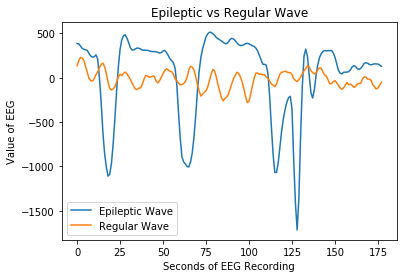

In [0]:
# Plot of an epileptic wave against a non-epileptic one.
# The dfColumnsNumber is computed with a -2 due to df containing "y" and "seizure"
# columns which are not subject to the plotting
dfColumnNumber = len(df.columns)
dfValColNum = dfColumnNumber - 2

plt.plot(range(dfValColNum), df.iloc[1,0:dfValColNum], label="Epileptic Wave")
plt.plot(range(dfValColNum), df.iloc[0,0:dfValColNum], label="Regular Wave")
plt.xlabel("Seconds of EEG Recording")
plt.ylabel("Value of EEG")
plt.legend()
plt.title("Epileptic vs Regular Wave")
plt.show()

From here on, I start preparing my data in a form acceptable for the NN. 

In [0]:
# Create dataframe containing only the EEG readings
dfReadings = df.drop(["seizure", "y"], axis=1)

# Create an array with each wave reading
wave = np.zeros((dfRowsNumber, dfValColNum))
i=0
for index, row in dfReadings.iterrows():
    wave[i,:] = row
    i += 1

In [0]:
# Setup a standardization for the data with mean equal to 0 and std equal to 1

# Standardize mean
mean = wave.mean(axis=0)
wave = wave - mean

# Standardize Standard Deviation
std = wave.std(axis=0)
wave = wave / std

# Setup Target for the Neural Net
target = df["seizure"].values

# Split data into test and train sets
x_train, x_test, y_train, y_test = train_test_split(wave, target, test_size=0.3, random_state=defaultSeed)

# Number of features
features_num = wave.shape[1]

I will build a [dense](https://keras.io/layers/core/) *Keras* network of layers and apply [dropout](https://keras.io/layers/core/#dropout)
to prevent overfitting. Most parameters were derived after studying *Keras* docs.

The rectified linear unit activation function ([ReLU](https://keras.io/layers/advanced-activations/#relu)) will be used on the first two layers and the [Sigmoid](https://keras.io/activations/#sigmoid) function in the output layer.

It used to be the case that **Sigmoid** and [Tanh](https://keras.io/activations/#tanh) activation functions were preferred for all layers. After some research, I came to the conclusion that better performance is achieved using the **ReLU** activation function.

The [hard_sigmoid](https://keras.io/activations/#hard_sigmoid) activation function, used in the output layer, assures that I will get as a result, a value between 0 and 1. It is used instead of the regular **Sigmoid** because of its faster computation.

Finally, [Dropout](https://keras.io/layers/core/#dropout) layers will be added in order to help prevent overfitting.

ref: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [0]:
# Build a keras network of layers and apply dropout (https://keras.io/layers/core/#dropout)
# to prevent overfitting. Most parameters were derived after studying Keras docs.
# The loss function of 'binary cross entropy' is specialized for binary classification problems.

# Create function returning a compiled network
def create_network(inputShape):
    # Setup the neural network
    network = Sequential()
    
    # Add input layer with a ReLU activation function
    network.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5), input_shape = (inputShape,)))
    
    # Add dropout layer
    network.add(layers.Dropout(0.5, seed=defaultSeed))

    # Add hidden layer
    network.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))

    # Add dropout layer
    network.add(layers.Dropout(0.5, seed=defaultSeed))

    # Add output layer with a sigmoid activation function
    network.add(layers.Dense(1, activation="sigmoid"))

    # Display the neural network
    network.summary()

    # Compile neural network
    network.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Return compiled network
    return network

## The best results overall were yielded by: {'layers': 2, 'nodes': 512, 'l2_value': 0.0001}
## But since on the test set the difference with {'layers': 1, 'nodes': 64, 'l2_value': 0.00001}
## were of 1e-3 and lower, I chose the second set of parameters due to the much
## faster alogrithm execution.

In [0]:
# Start the network
network = create_network(features_num)

# Fit the network
history = network.fit(x_train, y_train, epochs=200, batch_size=256, validation_split=0.2, verbose=1)

# After 100th epoch the test accuracy stabilizes but I will leave 200 epochs to 
# depict the stabilization in plot. 100 epochs are enough for the NN.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                11456     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________
Train on 6440 samples, validate on 1610 samples
Epoch 1/200
6440/6440 [==============================] - 1s 158us/samp

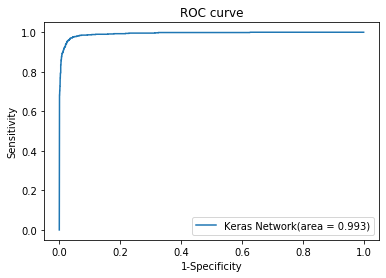

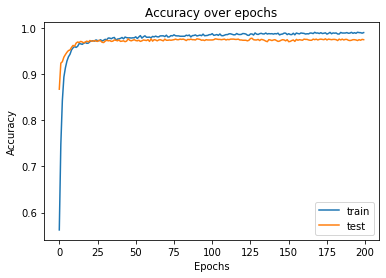

In [0]:
y_pred = network.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
AUC = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras Network(area = {:.3f})'.format(AUC))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# area ~= 0.992 with dropouts
# area ~= 0.988 without

# Accuracy over epochs plot
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# ***Cross Validation***

In [0]:
# Function that takes as input the neural net to perform validation on,
# the number of folds, the training set and the target values (classes)
def cross_validation(neural_net, num_folds, train_set, target_values):
    # define 10-fold cross validation
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=defaultSeed)
    fold_accuracy_scores = []
    counter = 1

    # Reminder:
    # wave -- contains all readings
    # target --  contains all results

    for train, test in kfold.split(train_set, target_values):
        # Compile model
        neural_net.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        # Fit the model
        neural_net.fit(train_set[train], target_values[train], epochs=200, batch_size=256, verbose=0)
        # evaluate the model
        scores = neural_net.evaluate(train_set[test], target_values[test], verbose=0)
        print("fold", counter, ": %s: %.2f%%" % (neural_net.metrics_names[1], scores[1]*100))
        fold_accuracy_scores.append(scores[1] * 100)
        counter+=1
    print("Average accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(fold_accuracy_scores), np.std(fold_accuracy_scores)))

In [0]:
cross_validation(network, 10, wave, target)

fold 1 : accuracy: 98.09%
fold 2 : accuracy: 98.70%
fold 3 : accuracy: 98.96%
fold 4 : accuracy: 97.83%
fold 5 : accuracy: 99.30%
fold 6 : accuracy: 98.70%
fold 7 : accuracy: 98.78%
fold 8 : accuracy: 99.22%
fold 9 : accuracy: 99.22%
fold 10 : accuracy: 99.13%
Average accuracy: 98.79% (+/- 0.47%)


# ***PCA***

Text(0, 0.5, 'Cumulative explained variance')

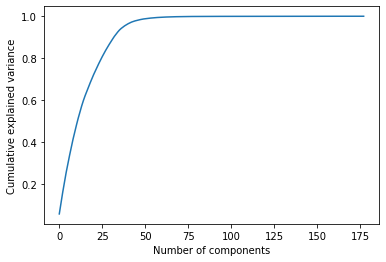

In [0]:
# Initially we use a number of components equal to the number of 
# features we have (features_num = 178)
pca = PCA(n_components=features_num)
pca.fit(x_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [0]:
# In the plot we can clearly see that the variance peaks around 50 components.
# That means that data describing changes is mostly contained in 50 components.
# We use 50 components for the PCA to check how it will work as it seems to have most of the data.

pca_components = 50

pca = PCA(n_components=pca_components)
x_pca_train = pca.fit_transform(x_train)

x_pca_test = pca.transform(x_test)
pca_std = np.std(x_pca_train)

print("Creting the a new network for PCA testing...")
pca_network = create_network(50)
print("Performing cross validation on the pca_network.")
cross_validation(pca_network, 10, x_pca_train, y_train)

Creting the a new network for PCA testing...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 7,489
Trainable params: 7,489
Non-trainable params: 0
_________________________________________________________________
Performing cross validation on the pca_network.
fold 1 : accuracy: 97.76%